In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import warnings

import matplotlib as mpl

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import train
import kernels
from svgd import SVGD

from jax.experimental import optimizers

rkey = random.PRNGKey(0)
basedir = "/home/lauro/code/msc-thesis/svgd/"

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Summary
both vanilla and mlp have big problems in trying to get anywhere near the target. Movement in mean (during run) is very similar.

In [2]:
def get_data(rundir):
    """Take directory with run results and return a Pandas DataFrame with the relevant hparams plus metrics.
    Returns:
    * frame: a pandas dataframe with config hparams and metrics
    * data: a list of dicts with data collected during runs"""
    cfgs = []
    rundata = []
    metrics = []
    sweep_metaconfigs = []
    base_metaconfigs = []
    for logdir in os.listdir(rundir):
        if os.path.isdir(os.path.join(rundir, logdir)):
            configfile, datafile, metricfile = [rundir + logdir + f for f in ["/config.json", "/rundata.json", "/metrics.json"]]
            with open(configfile, "r") as f:
                cfgs.append(json.load(f))
            try:
                with open(datafile, "r") as f:
                    rundata.append(json.load(f))
                with open(metricfile, "r") as f:
                    metrics.append(json.load(f))
            except FileNotFoundError:
                warnings.warn(f"No config / data files in {logdir}.")
        else:
            with open(rundir + logdir, "r") as f:
                base, sweep_config = json.load(f)
                sweep_metaconfigs.append(sweep_config)
                base_metaconfigs.append(base)
     
    # process data
    cfgs_flat = [utils.flatten_dict(c) for c in cfgs]
    for c in cfgs_flat:
        if len(c["optimizer_svgd_args"]) == 1:
            c["optimizer_svgd_args"] = onp.squeeze(c["optimizer_svgd_args"])
        if len(c["optimizer_ksd_args"]) == 1:
            c["optimizer_ksd_args"] = onp.squeeze(c["optimizer_ksd_args"])
    
    
    configs_df = pd.DataFrame(cfgs_flat)
    configs_df.rename(columns={"optimizer_svgd_args": "lr svgd", "optimizer_ksd_args": "lr ksd"}, inplace=True)
    
    metrics_df = pd.DataFrame(metrics)
    all_df = pd.concat([metrics_df, configs_df], axis=1)
    all_df["layers"] = all_df.layers.astype('str').astype('category')
    all_df["architecture"] = all_df.architecture.astype('str').astype('category')
    
    if all_df.isnull().values.any():
        rows_with_nans = all_df.shape[0] - all_df.dropna().shape[0]
        warnings.warn(f"Detected NaNs in dataframe. {rows_with_nans} / {all_df.shape[0]} rows include at least one NaN. Dropping all rows with NaNs.")
        all_df = all_df.dropna()

    return all_df, rundata, cfgs, sweep_metaconfigs, base_metaconfigs

In [4]:
# rundir = "../runs/four-dim/"
rundir = basedir + "runs/test-eval/"
frame, rundata, configs, sweep_metaconfigs, base_metaconfigs = get_data(rundir)
relevant = ["ksd", "emd", "sinkhorn_divergence"] + ["lr ksd", "svgd_steps", "architecture", "layers", "ksd_steps"]
f = frame[relevant]
# f

In [5]:
f

,ksd,emd,sinkhorn_divergence,lr ksd,svgd_steps,architecture,layers,ksd_steps
0,274.063647,17.590226,309.433619,0.1,1,MLP,"[32, 32, 32, 2]",1
1,233.723850,17.454214,304.662151,0.001,1,Vanilla,"[32, 32, 32, 2]",1
2,269.938762,17.675720,312.465914,0.01,1,MLP,"[32, 32, 32, 2]",1
3,231.515452,17.523217,307.072716,0.1,1,Vanilla,"[32, 32, 32, 2]",1
4,233.494401,17.556293,308.240974,0.01,1,Vanilla,"[32, 32, 32, 2]",1
5,225.633447,17.488249,305.855826,0.001,1,MLP,"[32, 32, 32, 2]",1


# Hyperparameter comparison

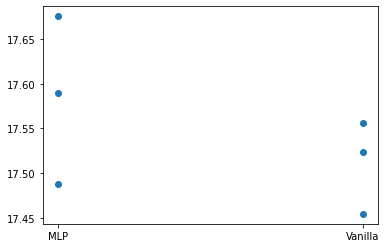

In [7]:
plt.scatter(f.architecture, f.emd)

# Rundata

In [10]:
rundata[0].keys()

odict_keys(['Interrupted because of NaN', 'ksd', 'ksd_after_kernel_update', 'mean', 'particles', 'square_errors', 'var'])

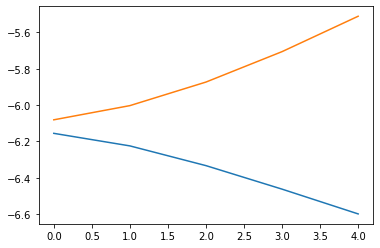

In [37]:
ind = 5
mean = onp.array(rundata[ind]["mean"])
_ = plt.plot(mean)

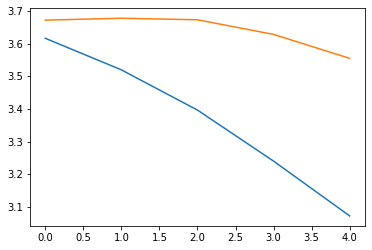

In [38]:
mean = onp.array(rundata[index]["var"])
_ = plt.plot(mean)

In [25]:
# rundata[ind]["square_errors"]

### KSD

In [44]:
ind = 1

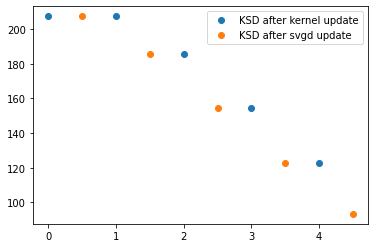

In [45]:
fig, ax = plt.subplots()
idx = onp.arange(5)
ax.plot(idx, onp.array(rundata[ind]["ksd"]), "o", label="KSD after kernel update")
ax.plot(idx + 0.5, onp.array(rundata[ind]["ksd_after_kernel_update"]), "o", label="KSD after svgd update")
plt.legend()

In [43]:
f

,ksd,emd,sinkhorn_divergence,lr ksd,svgd_steps,architecture,layers,ksd_steps
0,274.063647,17.590226,309.433619,0.1,1,MLP,"[32, 32, 32, 2]",1
1,233.723850,17.454214,304.662151,0.001,1,Vanilla,"[32, 32, 32, 2]",1
2,269.938762,17.675720,312.465914,0.01,1,MLP,"[32, 32, 32, 2]",1
3,231.515452,17.523217,307.072716,0.1,1,Vanilla,"[32, 32, 32, 2]",1
4,233.494401,17.556293,308.240974,0.01,1,Vanilla,"[32, 32, 32, 2]",1
5,225.633447,17.488249,305.855826,0.001,1,MLP,"[32, 32, 32, 2]",1
